# Part 3

Training set size: 756
Validation set size: 95
Test set size: 95

Preparing binary labels...

Binary class distribution (Training set):
binary_type
fake        580
reliable    176
Name: count, dtype: int64

Creating TF-IDF features...

Training Multinomial Naive Bayes...
Multinomial Naive Bayes - F1 Score: 0.9068 (Training time: 0.01 seconds)

Classification Report:
              precision    recall  f1-score   support

        fake       0.83      1.00      0.91        73
    reliable       1.00      0.32      0.48        22

    accuracy                           0.84        95
   macro avg       0.91      0.66      0.69        95
weighted avg       0.87      0.84      0.81        95


Training Linear SVM...
Linear SVM - F1 Score: 0.9299 (Training time: 0.07 seconds)

Classification Report:
              precision    recall  f1-score   support

        fake       0.87      1.00      0.93        73
    reliable       1.00      0.50      0.67        22

    accuracy                    

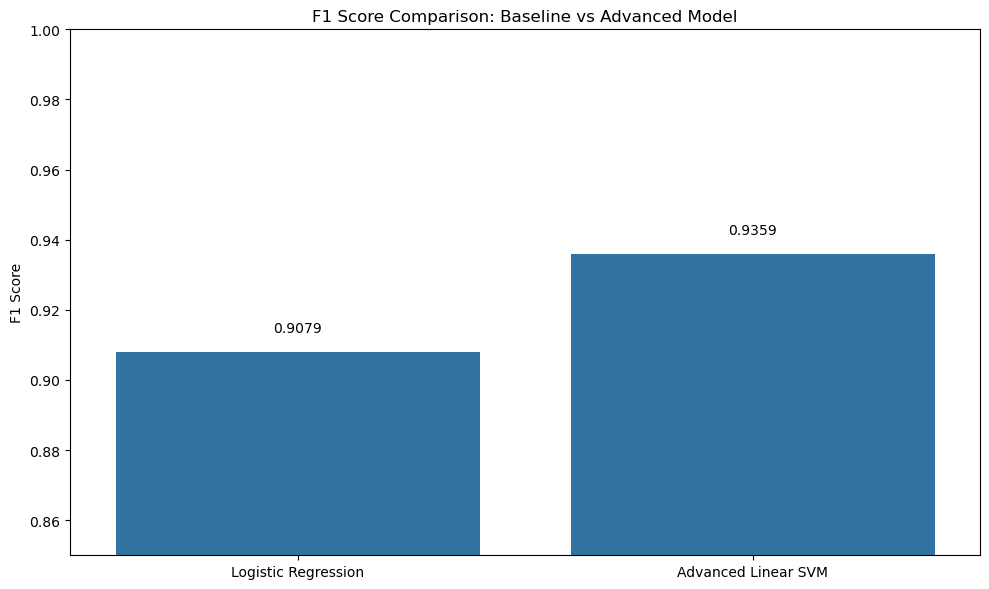

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix, make_scorer
from sklearn.model_selection import GridSearchCV
import time

train_df = pd.read_csv('train_data.csv')
val_df = pd.read_csv('validation_data.csv')
test_df = pd.read_csv('test_data.csv')

# Display dataset information
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Binary labels (same as in Part 2)
print("\nPreparing binary labels...")
reliable_types = ['reliable']
fake_types = ['fake', 'conspiracy', 'junksci', 'hate', 'unreliable', 
              'bias', 'satire', 'clickbait', 'political', 'rumor', 'unknown']

def create_binary_label(news_type):
    if pd.isna(news_type):
        return np.nan
    elif news_type in reliable_types:
        return 'reliable'
    elif news_type in fake_types:
        return 'fake'
    else:
        return np.nan

# Apply binary classification to all datasets
for dataset in [train_df, val_df, test_df]:
    dataset['binary_type'] = dataset['type'].apply(create_binary_label)

# Check the binary class distribution
print("\nBinary class distribution (Training set):")
print(train_df['binary_type'].value_counts())

# Create more advanced features using TF-IDF
print("\nCreating TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    min_df=5,
    max_df=0.8,
    ngram_range=(1, 2),  # Add bigrams
    sublinear_tf=True    # Apply sublinear tf scaling
)

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['content'])
X_val_tfidf = tfidf_vectorizer.transform(val_df['content'])
X_test_tfidf = tfidf_vectorizer.transform(test_df['content'])

# Create target variables
y_train = train_df['binary_type']
y_val = val_df['binary_type']
y_test = test_df['binary_type']

# Define a list of advanced models to try
models = {
    "Multinomial Naive Bayes": MultinomialNB(),
    "Linear SVM": LinearSVC(random_state=42, dual=False, max_iter=5000),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100, max_depth=20),
    "Neural Network": MLPClassifier(random_state=42, max_iter=300, hidden_layer_sizes=(100,50), early_stopping=True)
}

# Create custom f1 scorer
f1_scorer = make_scorer(f1_score, pos_label='fake')

# Train and evaluate each model
results = {}
best_model_name = None
best_f1 = 0

for name, model in models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    
    model.fit(X_train_tfidf, y_train)
    # Predict on validation set
    y_val_pred = model.predict(X_val_tfidf)
    val_f1 = f1_score(y_val, y_val_pred, pos_label='fake')
    training_time = time.time() - start_time
    # Store results
    results[name] = {
        'model': model,
        'f1_score': val_f1,
        'training_time': training_time
    }
    # Print results
    print(f"{name} - F1 Score: {val_f1:.4f} (Training time: {training_time:.2f} seconds)")
    print("\nClassification Report:")
    print(classification_report(y_val, y_val_pred))
    # Update best model
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_model_name = name

# Announce the best model
print(f"\nBest model: {best_model_name} with F1 Score: {best_f1:.4f}")

# Hyperparameter tuning for the best model
if best_model_name == "Multinomial Naive Bayes":
    param_grid = {
        'alpha': [0.01, 0.1, 0.5, 1.0, 2.0]
    }
    best_model = MultinomialNB()
    
elif best_model_name == "Linear SVM":
    param_grid = {
        'C': [0.1, 1, 10],
        'class_weight': [None, 'balanced']
    }
    best_model = LinearSVC(random_state=42, dual=False, max_iter=5000)
    
elif best_model_name == "Random Forest":
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 20, 30],
        'min_samples_split': [2, 5, 10]
    }
    best_model = RandomForestClassifier(random_state=42)
    
elif best_model_name == "Neural Network":
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (50,25), (100,50)],
        'alpha': [0.0001, 0.001, 0.01]
    }
    best_model = MLPClassifier(random_state=42, max_iter=300, early_stopping=True)

# Run grid search with the custom scorer
grid_search = GridSearchCV(
    best_model, 
    param_grid, 
    cv=3,
    scoring=f1_scorer,  # Use the custom f1 scorer
    n_jobs=-1
)

print(f"Running grid search for {best_model_name}...")
grid_search.fit(X_train_tfidf, y_train)

# Get the best model
tuned_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

# Evaluate the tuned model
y_val_pred = tuned_model.predict(X_val_tfidf)
tuned_f1 = f1_score(y_val, y_val_pred, pos_label='fake')
print(f"\nTuned {best_model_name} - F1 Score: {tuned_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

# Create confusion matrix for tuned model
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['reliable', 'fake'], 
            yticklabels=['reliable', 'fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Tuned {best_model_name}')
plt.tight_layout()
plt.savefig('advanced_model_confusion_matrix.png')
plt.close()

# Compare with baseline model from Part 2
print("\nComparison with baseline model from Part 2:")
print(f"Baseline Logistic Regression F1 Score: 0.9079")  # From Part 2
print(f"Best Advanced Model ({best_model_name}) F1 Score: {tuned_f1:.4f}")
improvement = ((tuned_f1 - 0.9079) / 0.9079) * 100
print(f"Improvement: {improvement:.2f}%")

# Plot model comparison
models_comparison = ['Logistic Regression', f'Advanced {best_model_name}']
f1_scores = [0.9079, tuned_f1]  # Baseline score from Part 2

plt.figure(figsize=(10, 6))
bars = sns.barplot(x=models_comparison, y=f1_scores)
plt.title('F1 Score Comparison: Baseline vs Advanced Model')
plt.ylabel('F1 Score')
plt.ylim(0.85, 1.0)  # Set y-axis to focus on the differences

# Add value labels on top of bars
for i, bar in enumerate(bars.patches):
    bars.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.005,
            f'{f1_scores[i]:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('baseline_vs_advanced_comparison.png')
plt.show()
plt.close()